In [1]:
using TSSM
using PyPlot
include("coupled_schroedinger.jl")
include("time_stepper.jl")

 *** OPENMP n_threads =           8


local_orders (generic function with 5 methods)

## Coupled Nonlinear Schrödinger equation

$$\mathrm{i}\left(\frac{\partial \psi_1}{\partial t}+\delta \frac{\partial \psi_1}{\partial x}\right)+\frac{1}{2}\frac{\partial^2\psi_1}{\partial x^2}+(|\psi_1|^2+e|\psi_2|^2)\psi_1=0,\\
\mathrm{i}\left(\frac{\partial \psi_2}{\partial t}+\delta \frac{\partial \psi_2}{\partial x}\right)+\frac{1}{2}\frac{\partial^2\psi_2}{\partial x^2}+(e|\psi_1|^2+|\psi_2|^2)\psi_2=0,\\
$$ and initial condition
$$\psi_1(x,0)=\sum_{j=1}^2\sqrt{\frac{2a_j}{1+e}}\sech(\sqrt{2\alpha_j}x_j)\exp(\mathrm{i}(v_j-\delta)x_j),\\
\psi_2(x,0)=\sum_{j=1}^2\sqrt{\frac{2a_j}{1+e}}\sech(\sqrt{2\alpha_j}x_j)\exp(\mathrm{i}(v_j-\delta)x_j)
$$
where $x_1=x$ and $x_2=x-25$ ande the other parameters as below.

In [2]:
const alpha1=1.0
const alpha2=0.5
const e=2/3.0
const v1=1.0
const v2=0.1
const delta=0.5

xmin=-20
xmax=60
nx=1024

1024

In [3]:
m=CoupledSchroedinger1D(nx,xmin,xmax, delta, e)
psia=wave_function(m)
psi_ref=wave_function(m)
psi=wave_function(m)

#initialcondition
function init1(x)
    (sqrt(2*alpha1/(1+e)) * sech(sqrt(2*alpha1)*(x))    * exp(1im*( (v1-delta)*x )))+
    (sqrt(2*alpha2/(1+e)) * sech(sqrt(2*alpha2)*(x-25)) * exp(1im*( (v2-delta)*(x-25) )))
end

function init2(x)
    (sqrt(2*alpha1/(1+e)) * sech(sqrt(2*alpha1)*(x))    * exp(1im*( (v1+delta)*x )))+
    (sqrt(2*alpha2/(1+e)) * sech(sqrt(2*alpha2)*(x-25)) * exp(1im*( (v2+delta)*(x-25) )))
end

init = Function2(init1,init2)

Function2(init1,init2)

In [4]:
include("schemes.jl")
tend=50.0
  t0=0.0
  tol=-5
  scheme=embedded_scheme_43
  out=1
  stepmin_ex=1

1

In [5]:
  x = get_nodes(m.m1)
  u1 = get_data(psia.psi1, true)
  u2 = get_data(psia.psi2, true)
  stepsa=[0.0]
  mytimea=[0.0]
  nstepsa=0
  steps=[0.0]
  mytime=[0.0]
  nsteps=0
  set!(psia, init)
  set!(psi, init)

  plotdata1=abs(u1).^2
  plotdata2=abs(u2).^2
  told=0.0

timea = @elapsed for t in adaptive_time_stepper(psia, t0, tend, 0.001, 10.0^tol, scheme, "AB")
  push!(stepsa,t-told)
  push!(mytimea,t)
  told=t
  nstepsa=nstepsa+1
  if out==1
     to_real_space!(psia.psi1)
     to_real_space!(psia.psi2)
     plotdata1 = [plotdata1 abs(u1).^2]
     plotdata2 = [plotdata2 abs(u2).^2]
  end
end

LoadError: LoadError: UndefVarError: adaptive_time_stepper1 not defined
while loading In[5], in expression starting on line 17

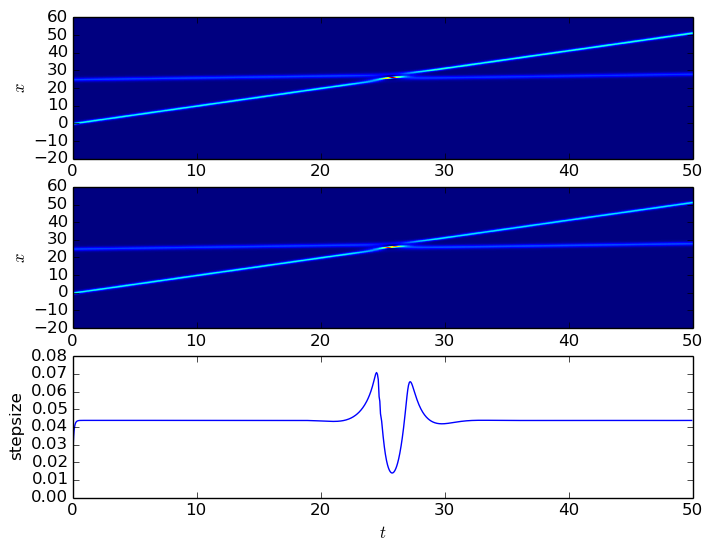

In [13]:
  figure(1)
  hold(false)
  if out==1
  subplot(3, 1, 1)
  pcolormesh(mytimea,x,plotdata1)
  xlabel("\$t\$")
  ylabel("\$x\$")
  subplot(3, 1, 2)
  pcolormesh(mytimea,x,plotdata2)
  xlabel("\$t\$")
  ylabel("\$x\$")
    #colorbar()
  axis([t0,tend,xmin,xmax])
  subplot(3, 1, 3)
  end
  plot(mytimea[1:end-2], stepsa[2:end-1])
  xlabel("\$t\$")
  ylabel("stepsize")
savefig("step.png", bbox_inches="tight")

In [6]:
include("my_helper.jl")

my_latex (generic function with 1 method)

In [7]:
tols=[-5,-8,-10];
out=0;
stepmin_ex=0;
latex=1;

In [8]:
set!(psi_ref, init) #compute ref_solution
@time for t in adaptive_time_stepper(psi_ref, t0, tend, 0.01, 1e-12, palindromic_scheme_56, "AB")
end

 39.160817 seconds (9.89 M allocations: 28.244 GB, 3.22% gc time)


In [9]:
@printf("Method & \\# steps adaptive & \\# steps equidist & time adaptive & time equidist \\\\ \\hline \n")
maxsteps=10^6
nrep=1
for tol in tols
    for scheme in schemes[1:3]
        steps_a=zeros(maxsteps)
        mytime=zeros(maxsteps)
        time_a=0.0
        nsteps_a=0
        for n in 1:nrep #average time over nrep runs
            told=0.0
            nsteps_a=0
            set!(psia, init)
            time_a =time_a+ @elapsed  for t in adaptive_time_stepper2(psia, t0, tend, 0.01, 10.0^tol, scheme, "AB")
                    nsteps_a=nsteps_a+1
                    steps_a[nsteps_a]=t-told
                    mytime[nsteps_a]=t
                    told=t    
            end
        end
        time_a=time_a/nrep
        stepmin=minimum(steps_a[1:nsteps_a-1])
        if out==1
            savefig!(scheme,schemes,mytime,steps_a,nsteps_a)
        end
        if stepmin_ex==1
            stepmin=calc_stepmin(psi_ref,psia,psi,scheme,init)
        end 
        steps=zeros(maxsteps)
        mytime=zeros(maxsteps)
        nsteps=0
        time=0.0
        for n in 1:nrep #average time over nrep runs
            told=0.0
            nsteps=0
            set!(psi, init)
            time = time + @elapsed  for t in equidistant_time_stepper(psi, t0, tend, stepmin, scheme, "AB")
                nsteps=nsteps+1
                steps[nsteps]=t-told
                mytime[nsteps]=t
                told=t 
            end
        end
        time=time/nrep
        if latex==1
            latextable(scheme,schemes,tol,nsteps_a,nsteps,time_a,time)
        end
    end
end

Method & \# steps adaptive & \# steps equidist & time adaptive & time equidist \\ \hline 
\texttt{Emb 4/3 AK p}, TOL = $ 10^{-5} $ & $ 1178 $ & $ 5001 $ & $ 2.646 $ & $ 5.880 $ \\ 
\texttt{PP 3/4 A}, TOL = $ 10^{-5} $ & $ 1806 $ & $ 5659 $ & $ 2.997 $ & $ 4.271 $ \\ 
\texttt{PP 5/6 A}, TOL = $ 10^{-5} $ & $ 582 $ & $ 5001 $ & $ 2.607 $ & $ 9.980 $ \\ \hline 
\texttt{Emb 4/3 AK p}, TOL = $ 10^{-8} $ & $ 6583 $ & $ 20227 $ & $ 13.068 $ & $ 23.598 $ \\ 
\texttt{PP 3/4 A}, TOL = $ 10^{-8} $ & $ 10222 $ & $ 32026 $ & $ 16.004 $ & $ 24.119 $ \\ 
\texttt{PP 5/6 A}, TOL = $ 10^{-8} $ & $ 2154 $ & $ 6643 $ & $ 9.182 $ & $ 13.373 $ \\ \hline 
\texttt{Emb 4/3 AK p}, TOL = $ 10^{-10} $ & $ 20813 $ & $ 63956 $ & $ 41.658 $ & $ 77.675 $ \\ 
\texttt{PP 3/4 A}, TOL = $ 10^{-10} $ & $ 32333 $ & $ 101293 $ & $ 49.602 $ & $ 107.493 $ \\ 
\texttt{PP 5/6 A}, TOL = $ 10^{-10} $ & $ 4856 $ & $ 14895 $ & $ 28.995 $ & $ 32.985 $ \\ \hline 


In [21]:
 nstep=10000
    tol=1e-5
    dt=0.01
    @printf("Method & %d steps without errorestimator & %d steps with errorestimator\\\\ \\hline \n",nstep,nstep)
    for scheme in schemes[1:3]
    set!(psi, init)
        time1 = @elapsed  for t in 1:nstep
            step!(psi, dt, scheme,"AB")
        end
        psi2=clone(psi)
        time2 = @elapsed  for t in 1:nstep
        if typeof(scheme)==PalindromicScheme
           copy!(psi, psi2)
           step_palindromic!(psi, psi2, dt, scheme.scheme, "AB")
           err = 0.5*distance(psi, psi2)/tol
        end
        if typeof(scheme)==EmbeddedScheme
           copy!(psi, psi2)
           step_embedded!(psi, psi2, dt, scheme.scheme1, scheme.scheme2, "AB")
           err = distance(psi, psi2)/tol
        end  
        if typeof(scheme)==DefectBasedScheme
            step_defect_based!(psi, psi2, dt, scheme.scheme, "AB")
            err = dt*norm(psi2)/(scheme.order+1)/tol
        end
    end
        if scheme==schemes[1]
            @printf("\\texttt{Emb 4/3 AK p} & \$ %5.3f \$ & \$ %5.3f \$ \\\\ \n",time1,time2)
        end
        if scheme==schemes[2]
            @printf(    "\\texttt{PP 3/4 A} & \$ %5.3f \$ & \$ %5.3f \$ \\\\ \n",time1,time2)
        end
        if scheme==schemes[3]
        @printf(    "\\texttt{PP 5/6 A} & \$ %5.3f \$ & \$ %5.3f \$ \\\\ \\hline \n",time1,time2)
        end
        if scheme==schemes[4]
            @printf("\\texttt{Emb 4/3 AK p (defect)} & \$ %5.3f \$ & \$ %5.3f \$ \\\\ \n",time1,time2)
        end
        if scheme==schemes[5]
            @printf(    "\\texttt{PP 3/4 A (defect)} & \$ %5.3f \$ & \$ %5.3f \$ \\\\ \n",time1,time2)
        end
        if scheme==schemes[6]
        @printf(    "\\texttt{PP 5/6 A (defect)} & \$ %5.3f \$ & \$ %5.3f \$ \\\\ \\hline \n",time1,time2)
        end
    end

Method & 10000 steps without errorestimator & 10000 steps with errorestimator\\ \hline 
\texttt{Emb 4/3 AK p} & $ 17.701 $ & $ 32.471 $ \\ 
\texttt{PP 3/4 A} & $ 11.177 $ & $ 23.398 $ \\ 
\texttt{PP 5/6 A} & $ 19.674 $ & $ 45.643 $ \\ \hline 
